In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as p # para algunas de las visualizaciones que haremos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable
import math

from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import expon
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf


# Análisis exploratorio

In [2]:
df = pd.read_csv("../data/train.csv", index_col = 0)

In [3]:
df.shape

(40455, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   x        40455 non-null  float64
 7   y        40455 non-null  float64
 8   z        40455 non-null  float64
 9   price    40455 non-null  float64
dtypes: float64(7), object(3)
memory usage: 3.4+ MB


Exploración de Nulos

In [5]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

Exploración y eliminación de duplicados

In [6]:
df.duplicated().sum()

85

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(40370, 10)

Gráfico de distribución para cada variable numérica

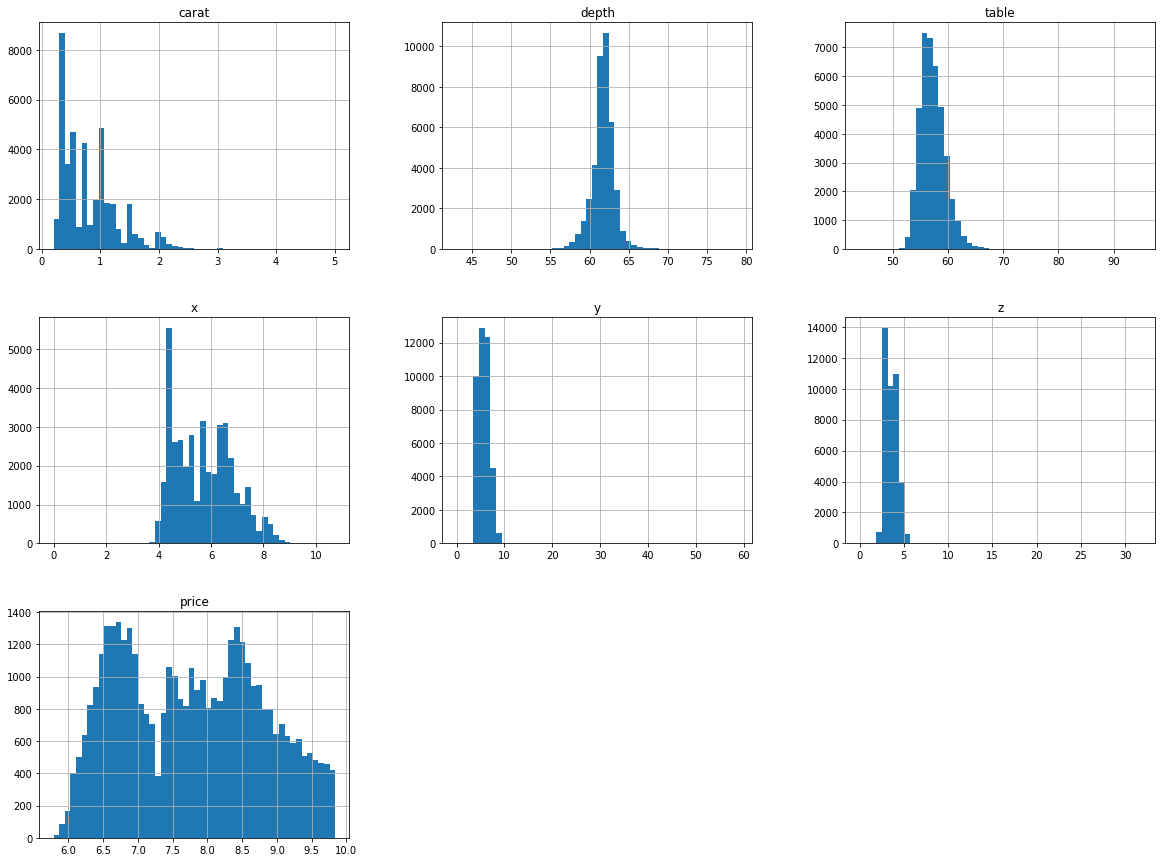

In [9]:
df.hist(bins = 50, figsize = (20,15))
plt.show()

Gráfico de relación entre variables predictoras y la variable a predecir

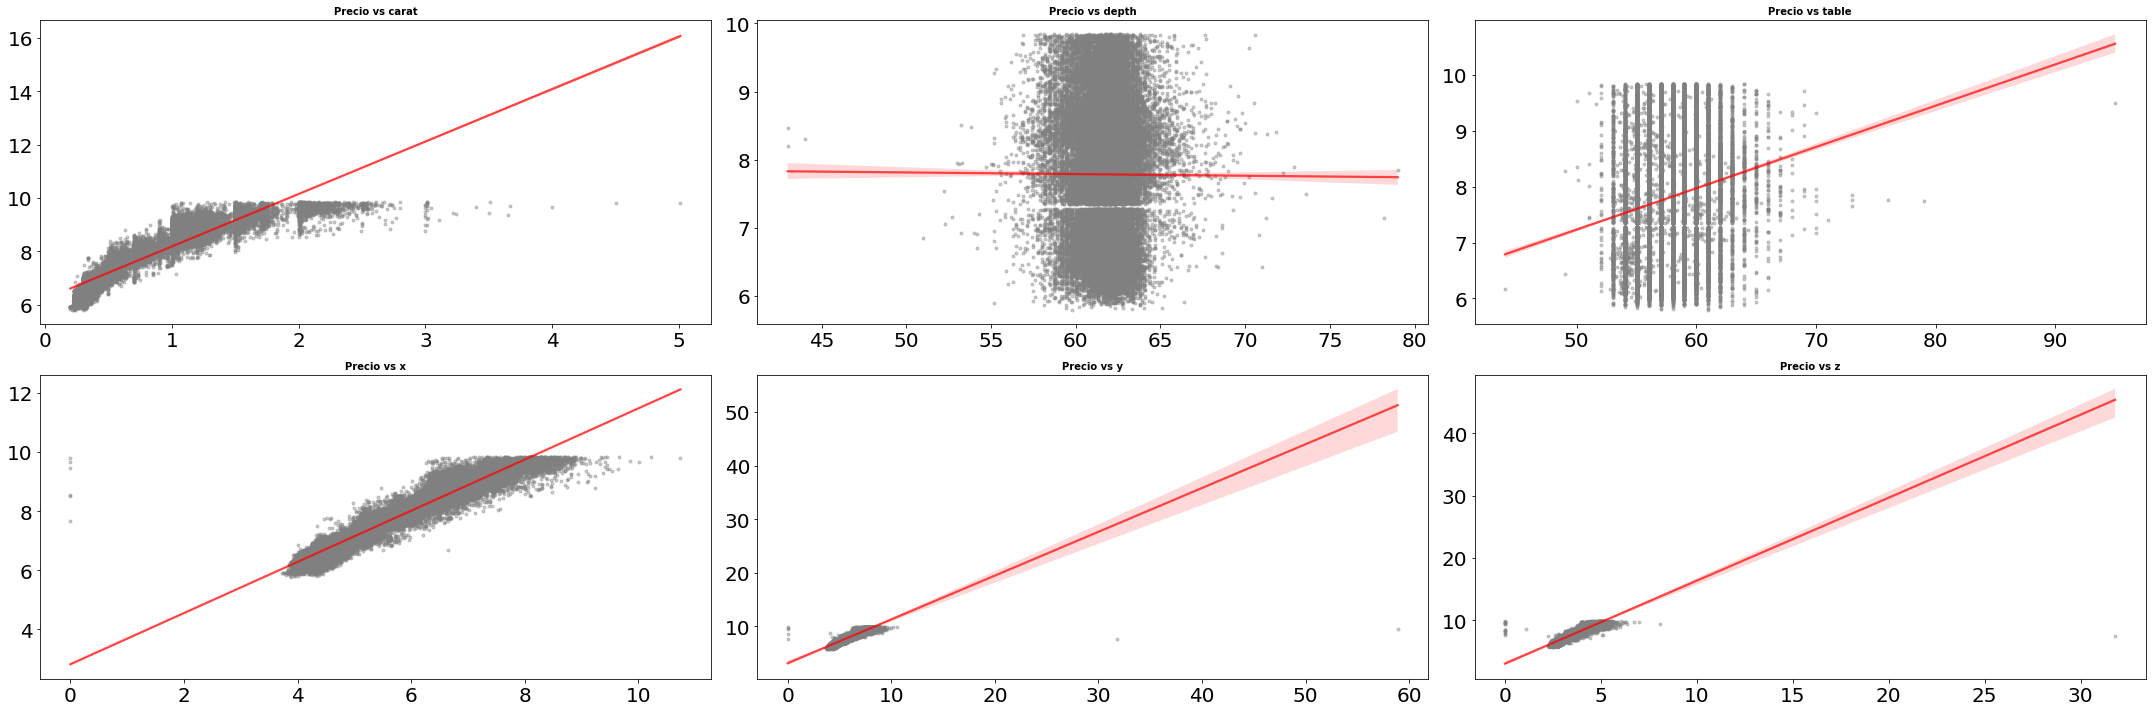

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange", "yellow"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("price")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Precio vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

Correlación entre variables numéricas¶

In [11]:
df.corr()

,carat,depth,table,x,y,z,price
carat,1.000000,0.023021,0.185219,0.974988,0.944654,0.947671,0.920157
depth,0.023021,1.000000,-0.298965,-0.030071,-0.034138,0.089297,-0.003403
table,0.185219,-0.298965,1.000000,0.200210,0.186573,0.153570,0.162379
x,0.974988,-0.030071,0.200210,1.000000,0.967204,0.965394,0.957965
y,0.944654,-0.034138,0.186573,0.967204,1.000000,0.940998,0.929091
z,0.947671,0.089297,0.153570,0.965394,0.940998,1.000000,0.930252
price,0.920157,-0.003403,0.162379,0.957965,0.929091,0.930252,1.000000


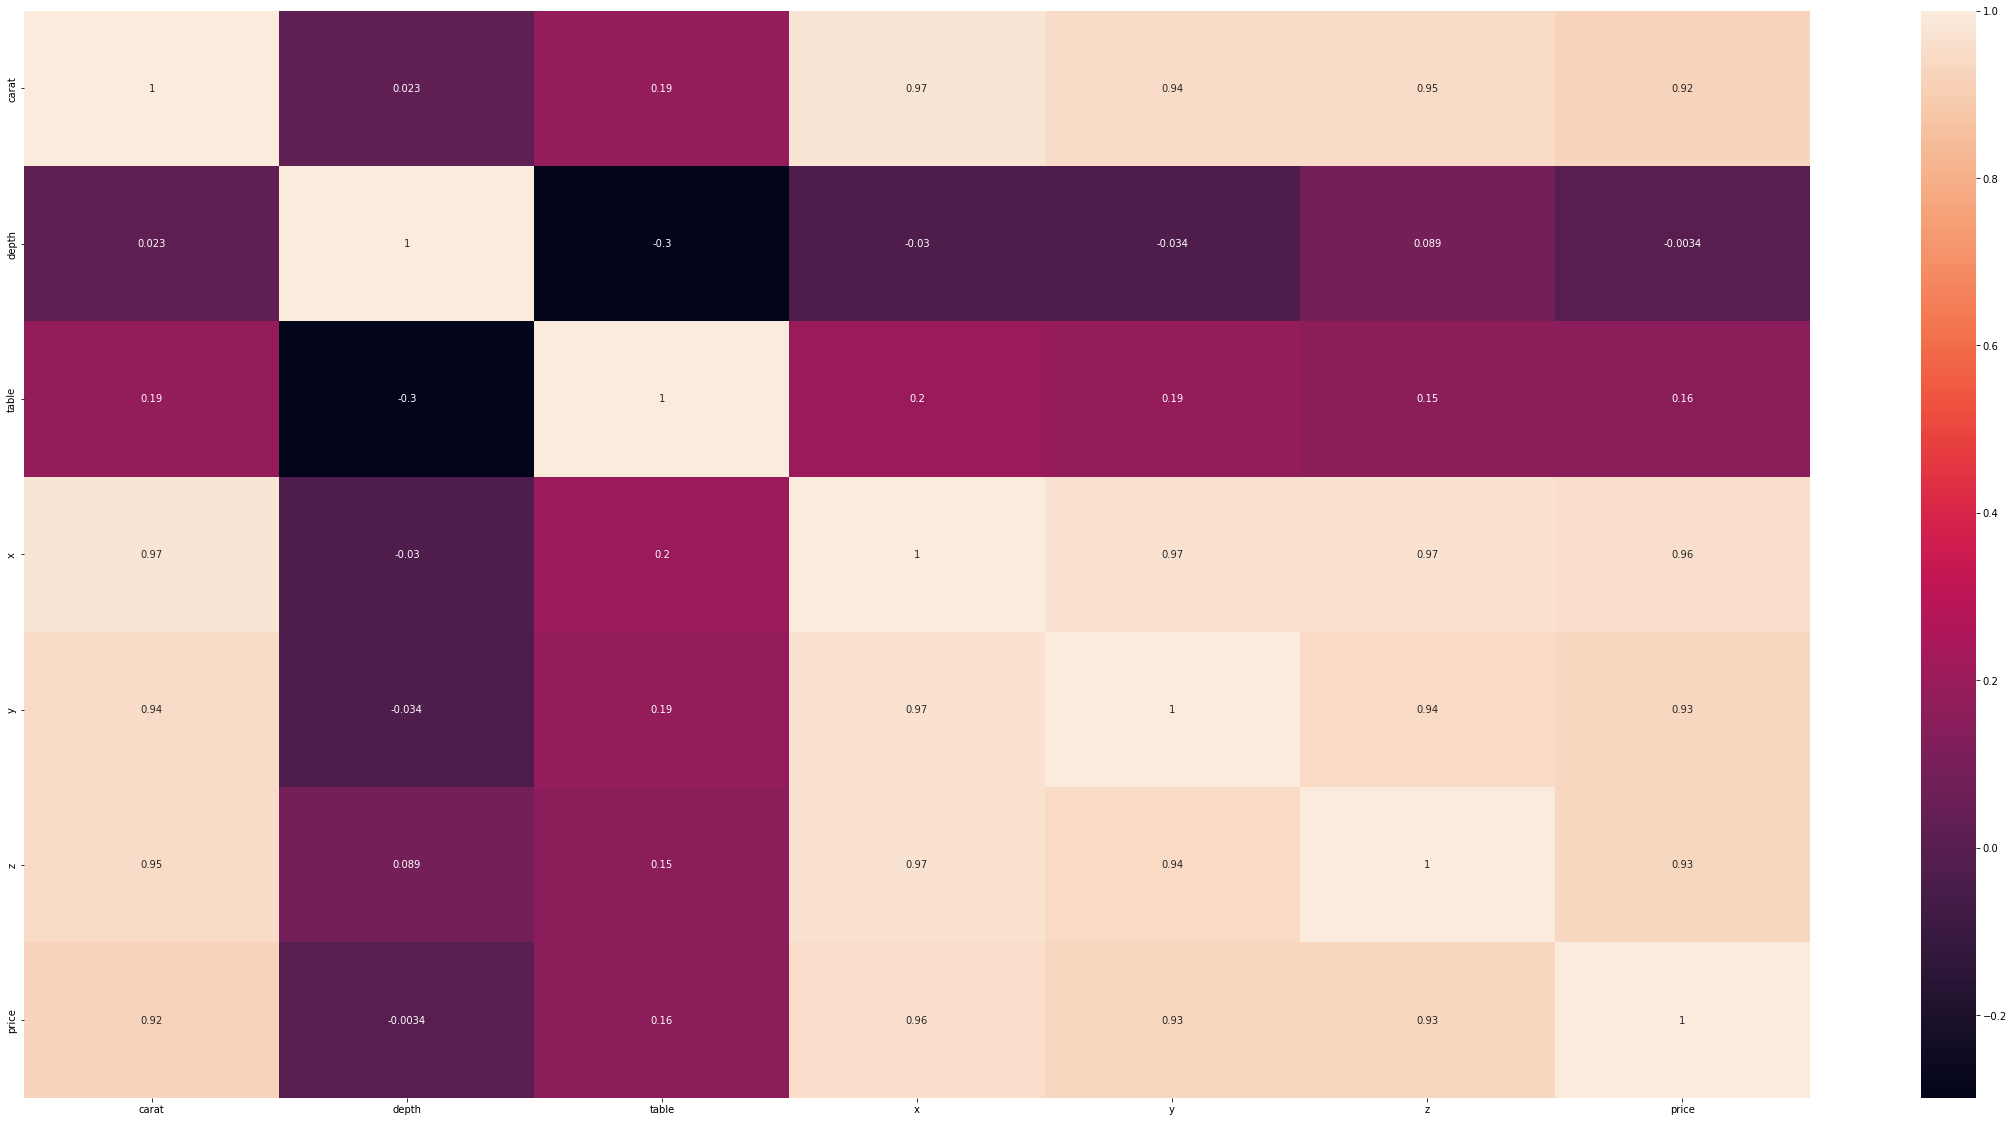

In [12]:
fig, ax = plt.subplots(figsize = (40,20))
sns.heatmap(df.corr(), annot = True)
plt.size = (40,40)
plt.show()

In [13]:
corr_matrix = df.corr()
corr_matrix["price"].sort_values(ascending=False)

price    1.000000
x        0.957965
z        0.930252
y        0.929091
carat    0.920157
table    0.162379
depth   -0.003403
Name: price, dtype: float64

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,40370.0,0.797478,0.475516,0.200,0.400,0.7000,1.040,5.010
depth,40370.0,61.745063,1.436153,43.000,61.000,61.8000,62.500,79.000
table,40370.0,57.452968,2.234980,44.000,56.000,57.0000,59.000,95.000
x,40370.0,5.729301,1.124362,0.000,4.710,5.6900,6.540,10.740
y,40370.0,5.733097,1.154051,0.000,4.720,5.7000,6.540,58.900
z,40370.0,3.537376,0.710448,0.000,2.910,3.5200,4.030,31.800
price,40370.0,7.784104,1.016725,5.787,6.851,7.7805,8.581,9.842


Eliminamos las variables que no guardan mucha correlación con el precio del diamante

In [15]:
columnas_eliminar = ['depth', 'table']

In [16]:
df_limpio = df.copy()

In [17]:
df_limpio.drop(columnas_eliminar, inplace=True, axis=1)

In [18]:
df_limpio.head(2)

,carat,cut,color,clarity,x,y,z,price
id,,,,,,,,
0,0.30,Premium,D,SI2,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,6.42,6.46,4.04,9.183


# Variables predictoras

Variable numéricas

In [19]:
df_numericas = df_limpio.select_dtypes(include=np.number)
df_numericas.head(2)

,carat,x,y,z,price
id,,,,,
0,0.30,4.31,4.28,2.68,6.353
1,1.01,6.42,6.46,4.04,9.183


Detectamos los Outliers

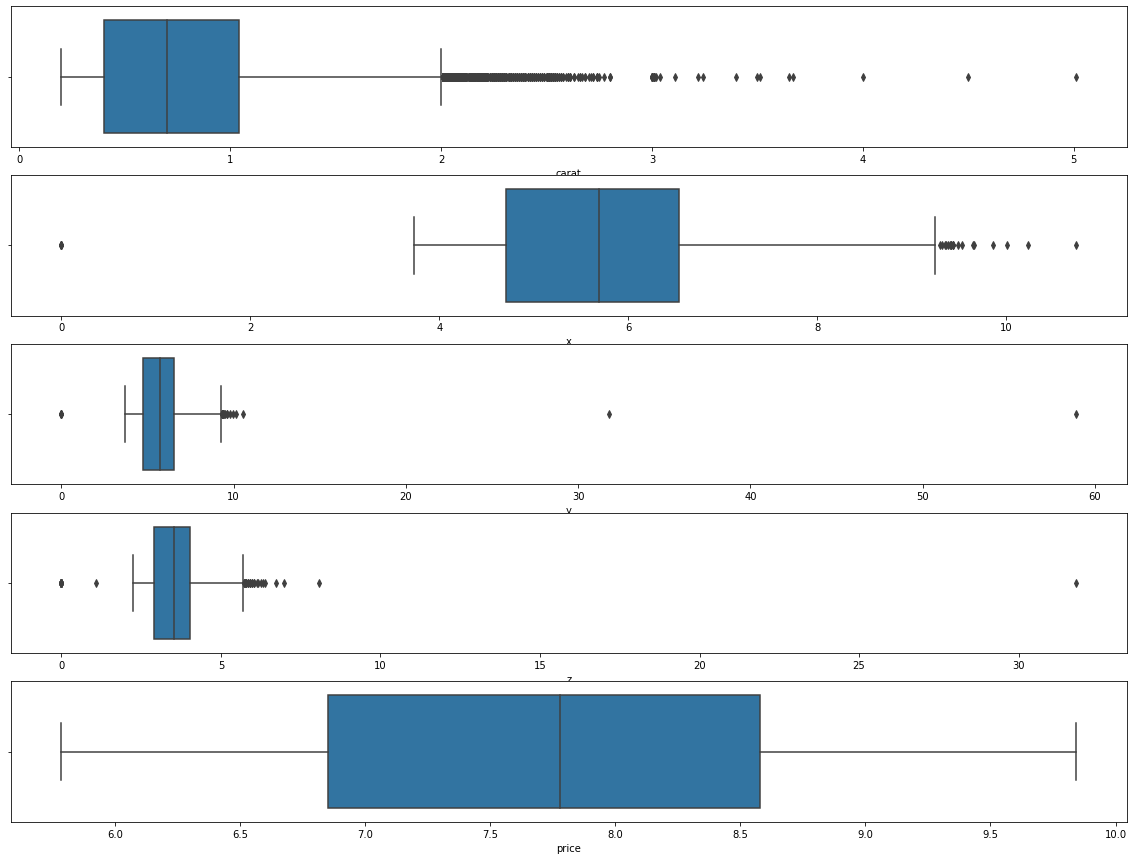

In [20]:
fig, ax = plt.subplots(5, 1, figsize=(20,15))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
plt.show()

In [21]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [22]:
lista_columnas = df_numericas.columns
lista_columnas

Index(['carat', 'x', 'y', 'z', 'price'], dtype='object')

In [23]:
ind = detectar_outliers(lista_columnas, df)
print(ind)

{'carat': [40, 85, 130, 173, 244, 264, 274, 289, 292, 295, 312, 346, 398, 574, 587, 662, 681, 682, 716, 725, 728, 782, 785, 798, 799, 801, 818, 928, 973, 993, 995, 1011, 1025, 1026, 1051, 1154, 1216, 1249, 1315, 1388, 1402, 1417, 1418, 1423, 1429, 1433, 1437, 1443, 1522, 1660, 1670, 1739, 1814, 1816, 1866, 1885, 1894, 1967, 1971, 1977, 1995, 2030, 2052, 2063, 2071, 2178, 2194, 2224, 2229, 2238, 2257, 2289, 2340, 2346, 2352, 2357, 2410, 2440, 2449, 2460, 2465, 2468, 2496, 2518, 2529, 2530, 2556, 2570, 2664, 2683, 2767, 2785, 2799, 2811, 2884, 2912, 2935, 2939, 2971, 2981, 3018, 3032, 3073, 3123, 3140, 3146, 3149, 3156, 3237, 3297, 3316, 3348, 3351, 3369, 3378, 3381, 3403, 3430, 3481, 3488, 3491, 3502, 3525, 3545, 3558, 3580, 3593, 3606, 3658, 3666, 3667, 3675, 3699, 3747, 3780, 3790, 3820, 3828, 3837, 3844, 3908, 4084, 4124, 4147, 4192, 4215, 4276, 4285, 4327, 4342, 4356, 4384, 4406, 4411, 4442, 4522, 4594, 4621, 4634, 4649, 4651, 4673, 4674, 4679, 4703, 4721, 4730, 4790, 4824, 4829, 48

In [24]:
ind.keys()

dict_keys(['carat', 'x', 'y', 'z'])

Sustituimos los Outliers por la mediana

In [25]:
for k, v in ind.items():
    mediana = df_limpio[k].median() # calculamos la media para cada una de las columnas que tenemos en nuestro diccionario
    for i in v: # iteremos por la lista de valores para cada columna
        df_limpio.loc[i,k] = mediana 

In [26]:
df_numericas2 = df_limpio.select_dtypes(include = np.number)

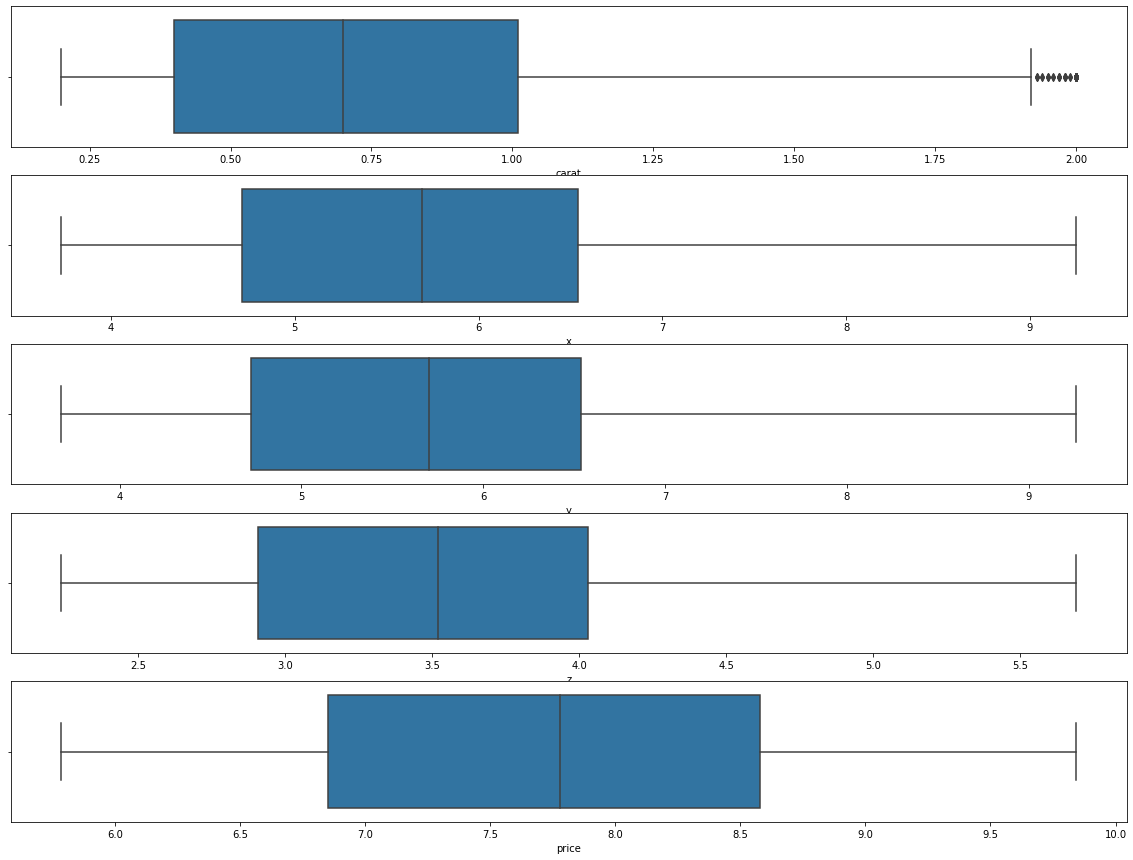

In [27]:
fig, ax = plt.subplots(5, 1, figsize=(20,15))

for i in range(len(df_numericas2.columns)):
    sns.boxplot(x=df_numericas2.columns[i], data=df_numericas2, ax=ax[i])
plt.show()

In [28]:
df_limpio.head(2)

,carat,cut,color,clarity,x,y,z,price
id,,,,,,,,
0,0.30,Premium,D,SI2,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,6.42,6.46,4.04,9.183


In [29]:
df_limpio.to_csv("df_sin_outliers")

# Encoding - Label encoding

Encoding Usando Map (son de tipo ordinales)

In [30]:
orden_cut = ["Ideal","Premium", "Very Good", "Good","Fair"] 
orden_color = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
orden_clarity = ['IF','VVS1','VVS2','VS1','VS2','SI1','SI2','I1']

In [31]:
def ordinal_encoder(orden, df, columna):
    ordinal = OrdinalEncoder(categories = [orden], dtype = int)
    transformados_oe = ordinal.fit_transform(df[[columna]])
    df[columna] = transformados_oe

    return df


In [32]:
df_limpio = ordinal_encoder(orden_cut, df_limpio, "cut")
df_limpio = ordinal_encoder(orden_color, df_limpio, "color")
df_limpio = ordinal_encoder(orden_clarity, df_limpio, "clarity")

df_limpio.head()

,carat,cut,color,clarity,x,y,z,price
id,,,,,,,,
0,0.30,1,0,6,4.31,4.28,2.68,6.353
1,1.01,0,1,2,6.42,6.46,4.04,9.183
2,0.72,0,2,4,5.71,5.74,3.54,7.983
3,1.08,2,3,6,6.54,6.50,4.12,8.371
4,0.36,1,3,3,4.50,4.55,2.82,6.588


In [33]:
df3 = df_limpio.copy()
df3.head()

,carat,cut,color,clarity,x,y,z,price
id,,,,,,,,
0,0.30,1,0,6,4.31,4.28,2.68,6.353
1,1.01,0,1,2,6.42,6.46,4.04,9.183
2,0.72,0,2,4,5.71,5.74,3.54,7.983
3,1.08,2,3,6,6.54,6.50,4.12,8.371
4,0.36,1,3,3,4.50,4.55,2.82,6.588


¿Qué distribución tienen nuestros datos?

In [34]:
num = df3[["carat", "x", "y", "z", "price"]]
num.head()

,carat,x,y,z,price
id,,,,,
0,0.30,4.31,4.28,2.68,6.353
1,1.01,6.42,6.46,4.04,9.183
2,0.72,5.71,5.74,3.54,7.983
3,1.08,6.54,6.50,4.12,8.371
4,0.36,4.50,4.55,2.82,6.588


In [35]:
columnas = num.columns
columnas

Index(['carat', 'x', 'y', 'z', 'price'], dtype='object')

Distribucion de cada variable

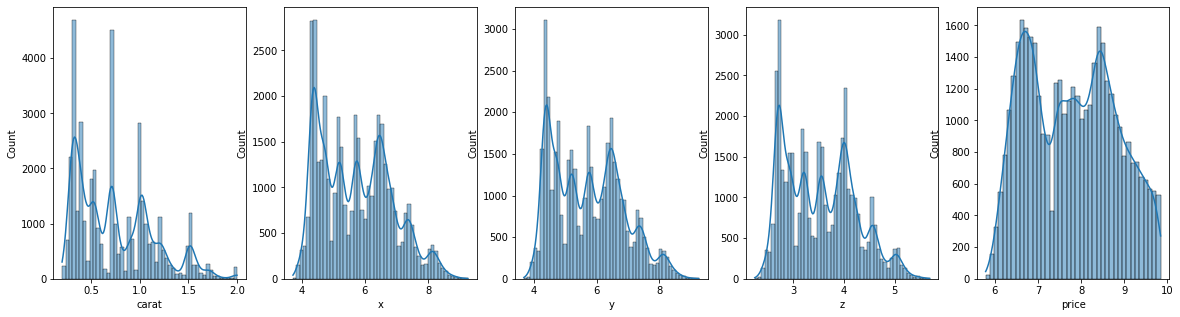

In [36]:
fig, ax = plt.subplots(1,5, figsize = (20,5))

for i in range(len(columnas)):
    sns.histplot(num[columnas[i]], kde = True, ax = ax[i])
plt.show()

In [37]:
columnas_eliminar2 = ['x', 'y', 'z']

In [38]:
df3.drop(columnas_eliminar2, inplace=True, axis=1)

# Normalizacion

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


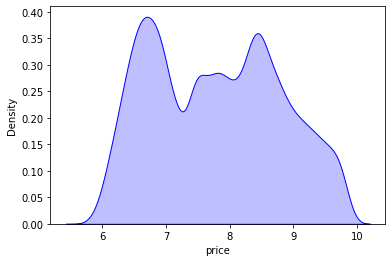

In [39]:
sns.distplot(
    df3.price, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

Método min max

In [40]:
media = df3["price"].mean()
maximo = df3["price"].max() 
minimo = df3["price"].min()

In [41]:
df3["price_NORM"] = (df3["price"] - media) / (maximo - minimo )

In [42]:
df3.head(2)

,carat,cut,color,clarity,price,price_NORM
id,,,,,,
0,0.30,1,0,6,6.353,-0.352923
1,1.01,0,1,2,9.183,0.344981


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


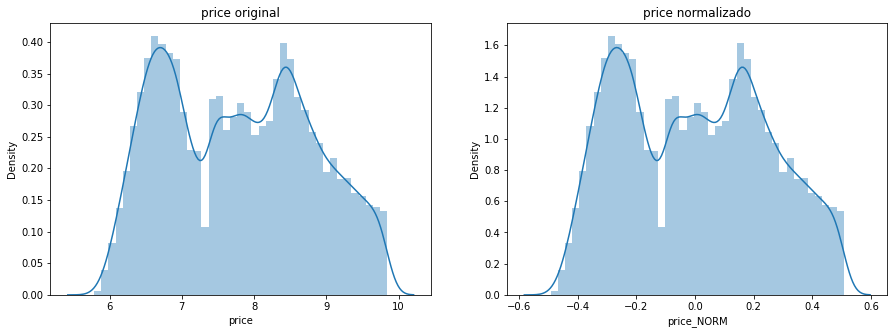

In [43]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df3['price'] ,ax = axes[0])
sns.distplot(df3['price_NORM'], ax = axes[1]);

Transformaciones logarítmicas

In [44]:
df3['price_LOG'] = df3['price'].apply(lambda x: np.log(x) if x != 0 else 0)

In [45]:
df3.head(2)

,carat,cut,color,clarity,price,price_NORM,price_LOG
id,,,,,,,
0,0.30,1,0,6,6.353,-0.352923,1.848927
1,1.01,0,1,2,9.183,0.344981,2.217354


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


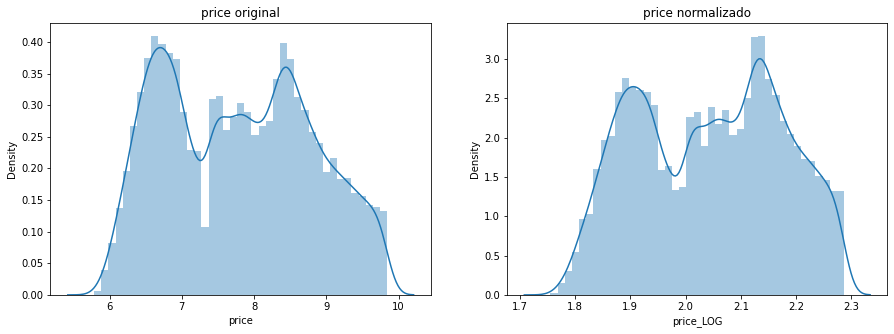

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df3['price'] ,ax = axes[0])
sns.distplot(df3['price_LOG'], ax = axes[1]);

Transformaciones raiz cuadrada

In [47]:
 df3['price_SQRT'] = df3['price'].apply(lambda x: math.sqrt(x))

In [48]:
df3.head(2)

,carat,cut,color,clarity,price,price_NORM,price_LOG,price_SQRT
id,,,,,,,,
0,0.30,1,0,6,6.353,-0.352923,1.848927,2.520516
1,1.01,0,1,2,9.183,0.344981,2.217354,3.030347


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


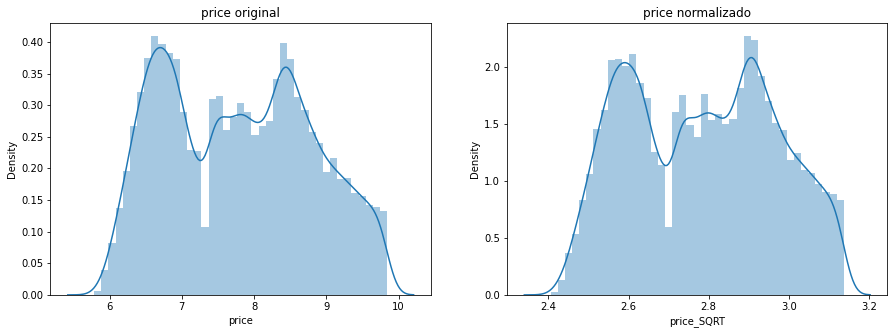

In [49]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df3['price'] ,ax = axes[0])
sns.distplot(df3['price_SQRT'], ax = axes[1]);

BoxCox

In [50]:
fitted_data, fitted_lambda = stats.boxcox(df3['price'])

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Lambda value used for Transformation: 0.21967361155455273


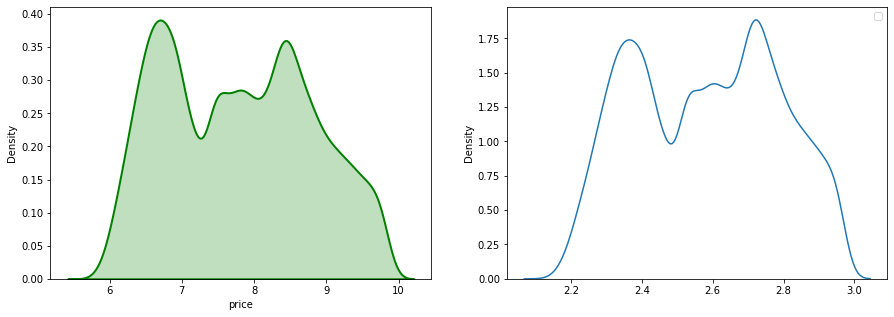

In [51]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
  
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(df3['price'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(fitted_data, hist = False, kde = True)
  
# adding legends to the subplots
plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(15)
  
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [52]:
fitted_data, fitted_lambda = stats.boxcox(df3['price'])
df3['price_BOXCOX'] = fitted_data

In [53]:
df3.head()

,carat,cut,color,clarity,price,price_NORM,price_LOG,price_SQRT,price_BOXCOX
id,,,,,,,,,
0,0.30,1,0,6,6.353,-0.352923,1.848927,2.520516,2.280854
1,1.01,0,1,2,9.183,0.344981,2.217354,3.030347,2.856874
2,0.72,0,2,4,7.983,0.049050,2.077314,2.825420,2.632418
3,1.08,2,3,6,8.371,0.144734,2.124773,2.893268,2.707714
4,0.36,1,3,3,6.588,-0.294970,1.885250,2.566710,2.335594


Como comclusión vemos que no se puede normalizar el precio, por loq ue nos quedamos con la columna original

Eliminamos las columnas normalizadas

In [54]:
columnas_eliminar3 = ["price_NORM" , "price_LOG", "price_SQRT", "price_BOXCOX"]

In [55]:
df3.drop(columnas_eliminar3, inplace=True, axis=1)

# Estandarización

Estandarización con Sklearn StandardScaler

In [56]:
scaler = StandardScaler()
scaler.fit(df3[["carat"]])
X_escaladas = scaler.transform(df3[["carat"]])
df3[['carat']] = X_escaladas
df3.head(2)

,carat,cut,color,clarity,price
id,,,,,
0,-1.128026,1,0,6,6.353
1,0.669489,0,1,2,9.183


In [57]:
df3.to_csv("../data/preproc.csv")

# Aplicamos misma limpieza al CSV de test

In [58]:
df_test = pd.read_csv("../data/test (2).csv")

In [59]:
columnas_eliminar_test = ['depth', 'table', 'x', 'y', 'z','id']

In [60]:
df_test.drop(columnas_eliminar_test, inplace=True, axis=1)

In [61]:
orden_cut = ["Ideal","Premium", "Very Good", "Good","Fair"] 
orden_color = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
orden_clarity = ['IF','VVS1','VVS2','VS1','VS2','SI1','SI2','I1']

In [62]:
df_test = ordinal_encoder(orden_cut, df_test, "cut")
df_test = ordinal_encoder(orden_color, df_test, "color")
df_test = ordinal_encoder(orden_clarity, df_test, "clarity")

In [63]:
scaler.fit(df_test[["carat"]])
X_escaladas = scaler.transform(df_test[["carat"]])
df_test[['carat']] = X_escaladas
df_test.head(2)

,carat,cut,color,clarity
0,-1.023184,0,5,5
1,0.941880,1,5,5


In [64]:
df_test.to_csv("../data/test_limpio_.csv")